# Play with OpenVINO in jupyter notebook

Enviroment setup is done as described in [here](./enable_openvino_in_jupyter.md)

 - C++: src/inference/src/ie_core.cpp
 - Python: src/bindings/python/src/pyopenvino/core/core.cpp


In [72]:
from openvino.preprocess import PrePostProcessor
import openvino.runtime as ov
import numpy as np
import time
from pandas import DataFrame

# this is top object
core = ov.Core()

proplist = []

for id, dev in enumerate(core.available_devices):
    v=core.get_versions(dev)[dev]
    proplist.append([dev, v.description, "{}.{}".format(v.major, v.minor, v.build_number)])
    SUPPORTED_PROPERTIES = core.get_property(dev, "SUPPORTED_PROPERTIES")
    for prop, rw in SUPPORTED_PROPERTIES.items():
        try:
            value = core.get_property(dev, prop)
        except:
            value = "(ERROR)"
        proplist.append(["...", prop, rw, value])
df = DataFrame(proplist)
df

,0,1,2,3
0,CPU,openvino_intel_cpu_plugin,2022.1,None
1,...,SUPPORTED_PROPERTIES,RO,"{'SUPPORTED_PROPERTIES': 'RO', 'AVAILABLE_DEVI..."
2,...,AVAILABLE_DEVICES,RO,[]
3,...,RANGE_FOR_ASYNC_INFER_REQUESTS,RO,"(1, 1, 1)"
4,...,RANGE_FOR_STREAMS,RO,"(1, 88)"
5,...,FULL_DEVICE_NAME,RO,Intel(R) Xeon(R) CPU E5-2699 v4 @ 2.20GHz
6,...,OPTIMIZATION_CAPABILITIES,RO,"[FP32, FP16, INT8, BIN, IMPORT_EXPORT]"
7,...,NUM_STREAMS,RW,1
8,...,AFFINITY,RW,(ERROR)
9,...,INFERENCE_NUM_THREADS,RW,0


## Model description API

ov.op/opset8/Model is for describing model using python. but this is not typical usage since openvino do not train NN.

 - src/bindings/python/src/pyopenvino/graph/node.cpp
 - src/core/src/model.cpp
 - src/bindings/python/src/pyopenvino/graph/model.cpp

In [73]:
# input
input_shape = [2, 3, 7, 7]
param_node = ov.op.Parameter(ov.Type.f32, ov.Shape(input_shape))
print('param_node: {}'.format(param_node))

# convolution weights in shape [out_channels, in_channels, kernel_height, kernel_width]
padding_begin = padding_end = [0, 0]
conv_kernel = ov.op.Constant(ov.Type.f32, ov.Shape([1,3,1,1]), np.ones([3]))
conv_node = ov.opset8.convolution(param_node, conv_kernel, [1, 1], padding_begin, padding_end, [1, 1])

# we can see shape inference happens immediatly
print('conv_node:{}'.format(conv_node))

maxpool_node = ov.opset1.max_pool(conv_node, [4, 4], padding_begin, padding_end, [4, 4], 'ceil')
print('maxpool_node:{}'.format(maxpool_node))

relu_node = ov.opset8.relu(maxpool_node)
reshape_node = ov.opset8.reshape(relu_node, [-1], False)
model = ov.Model(reshape_node, [param_node], 'cnntest')

print(model)

param_node: <Parameter: 'Parameter_10552' ({2,3,7,7}, float)>
conv_node:<Convolution: 'Convolution_10554' ({2,1,7,7})>
maxpool_node:<MaxPool: 'MaxPool_10555' ({2,1,2,2})>
<Model: 'cnntest'
inputs[
<ConstOutput: names[Parameter_10552] shape{2,3,7,7} type: f32>
]
outputs[
<ConstOutput: names[] shape{8} type: f32>
]>


Here is a simple piece of code for examining the model in a human-friendly way, just like `onnx.helper.printable_graph()`:

In [74]:
# print Model in readable text
def print_model(model):
    out2name = {}
    nameid = 1

    ilist = [i.get_node().get_name() for i in model.inputs]
    print("model({}):".format(",".join(ilist)))
    for n in model.get_ordered_ops():
        # collect output and also allocate output names
        returns = []
        for out in n.outputs():
            varname = "t{}".format(nameid)
            returns.append(varname)
            out2name[out] = varname
            nameid += 1
        # collect source output names of corresponding inputs
        args = [out2name[i.get_source_output()] for i in n.inputs()]

        # generate psuedo code
        print("    {} = {}({})  #{}: {}".format(",".join(returns), \
                        n.get_type_name(),
                        ",".join(args), \
                        n.get_friendly_name(), \
                        n.get_attributes()))
    olist = [out2name[i] for i in model.outputs]
    print("    return {}".format(",".join(olist)))

print_model(model)

model(Parameter_10552):
    t1 = Parameter()  #Parameter_10552: {'element_type': 'f32'}
    t2 = Constant()  #Constant_10553: {'element_type': 'f32', 'shape': [1, 3, 1, 1]}
    t3 = Convolution(t1,t2)  #Convolution_10554: {'strides': [1, 1], 'dilations': [1, 1], 'pads_begin': [0, 0], 'pads_end': [0, 0], 'auto_pad': 'explicit'}
    t4 = MaxPool(t3)  #MaxPool_10555: {'strides': [4, 4], 'pads_begin': [0, 0], 'pads_end': [0, 0], 'kernel': [4, 4], 'rounding_type': 'ceil', 'auto_pad': 'explicit'}
    t5 = Relu(t4)  #Relu_10556: {}
    t6 = Constant()  #Constant_10557: {'element_type': 'i64', 'shape': [1]}
    t7 = Reshape(t5,t6)  #Reshape_10558: {'special_zero': False}
    t8 = Result(t7)  #Result_10564: {}
    return t8


the `Model` here is high-level device-independent representation of CNN in openvino, most of the time user get this by converting from models of other NN frameworks.

# Model convert(import) APIs

src/bindings/python/src/pyopenvino/core/core.cpp

## Check supportiveness of a Model

Usually user just call compile_model() on a device w/o this step.

In [75]:
# returns  Pairs a operation name -> a device name supporting this operation.
for opname, devname in core.query_model(model, 'CPU').items():
    print("{} is supported by {}".format(opname, devname))

Constant_10553 is supported by CPU
Constant_10557 is supported by CPU
Convolution_10554 is supported by CPU
MaxPool_10555 is supported by CPU
Parameter_10552 is supported by CPU
Relu_10556 is supported by CPU
Reshape_10558 is supported by CPU
Result_10564 is supported by CPU


## Compile model on particular device

In [76]:
device = 'CPU'
# enable PERF_COUNT
core.set_property(device, {"PERF_COUNT": "YES"})
compiled_model = core.compile_model(model, device)

# exported model is actually the IR in xml format
user_stream = compiled_model.export_model()
with open('./my_model', 'wb') as f:
    f.write(user_stream)

!echo "exported model is saved to " `realpath ./my_model`

# import_model also returns a compiled model
#core.import_model("./my_model",'CPU')

# runtime model is internal low-level executable graph for particular device
# although still a ngraph function, but it uses different set of op (`ExecutionNode`)
# to represent internal OP
print("=============runtime model=============")
runtime_model = compiled_model.get_runtime_model()
print_model(runtime_model)


exported model is saved to  /home/hddl/NN-runtimes/OpenVINO/my_model
=============runtime model=============
model(Parameter_13119):
    t1 = Parameter()  #Parameter_10552: {'element_type': 'f32'}
    t2 = ExecutionNode()  #Constant_10553: {}
    t3 = ExecutionNode(t2)  #Constant_10553_abcd_Acdb8a_Convolution_10554: {}
    t4 = ExecutionNode(t1,t3)  #Convolution_10554: {}
    t5 = ExecutionNode(t4)  #Convolution_10554_aBcd8b_abcd_MaxPool_10555: {}
    t6 = ExecutionNode(t5)  #MaxPool_10555: {}
    t7 = ExecutionNode()  #Constant_10557: {}
    t8 = ExecutionNode(t6,t7)  #Reshape_10558: {}
    t9 = Result(t8)  #Result_10564: {}
    return t9


The APIs and relationships can be visualized as following:

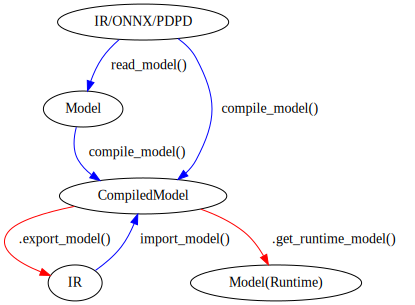

In [77]:
from graphviz import Digraph, Source
g = Digraph("openvino models relationship")
g.node(name='Model')
g.node(name='CompiledModel')
g.node(name='IR')
g.node(name='IR/ONNX/PDPD')
g.node(name='Model(Runtime)')

g.edge('Model','CompiledModel',label='compile_model()', color='blue')
g.edge('CompiledModel','IR',label='.export_model()', color='red')
g.edge('IR/ONNX/PDPD','CompiledModel',label='compile_model()', color='blue')
g.edge('IR/ONNX/PDPD','Model',label='read_model()', color='blue')
g.edge('IR','CompiledModel',label='import_model()', color='blue')
g.edge('CompiledModel','Model(Runtime)',label='.get_runtime_model()', color='red')

Source(g)

# Inference

 - src/bindings/python/src/pyopenvino/core/compiled_model.cpp

### check input/output information of the model

 - src/bindings/python/src/pyopenvino/graph/node_output.hpp

In [78]:
# check inputs & outputs (they are actually graph op)
# these are `ov::Output<const ov::Node>` type internally
for k, input in enumerate(compiled_model.inputs):
    print("inputs[{}]: {}".format(k,input))
for k, output in enumerate(compiled_model.outputs):
    print("outputs[{}]: {}".format(k,output))

inputs[0]: <ConstOutput: names[Parameter_10552] shape{2,3,7,7} type: f32>
outputs[0]: <ConstOutput: names[] shape{8} type: f32>


### Synchronously:  CompiledModel.infer_new_request()

Steps:
 - Create input `ov.Tensor`: src/bindings/python/src/pyopenvino/core/tensor.
 - Feed data into tensor
 - invoke `infer_new_request()`

 This is low-performance API

In [79]:
# get output description of the model
inode = compiled_model.input(0)

# numpy array can also be input of infer_new_request()
# but Tensor is best since it understands element_type while numpy don't
input = ov.Tensor(inode.get_element_type(), inode.get_shape())

# the data member is numpy array wrapper of the tensor
# so we can manipulate data using numpy
input.data[0,:,:,:] = 1
input.data[1,:,:,:] = 2

# infer_new_request is synchronous API
# the key in input dict can be int/string/opNode
param_name = list(compiled_model.input(0).names)[0]
result = compiled_model.infer_new_request({0:input})
result = compiled_model.infer_new_request({param_name:input})
result = compiled_model.infer_new_request({compiled_model.input(0):input})

print(result)

{<ConstOutput: names[] shape{8} type: f32>: array([3., 3., 3., 3., 6., 6., 6., 6.], dtype=float32)}


### Asynchronously:  infer_request/async_infer_queue

 - src/inference/src/cpp/ie_infer_request.cpp
 - src/bindings/python/src/pyopenvino/core/infer_request.cpp
 - src/bindings/python/src/pyopenvino/core/async_infer_queue.cpp

This concept of infer_request is important:
 - it has input/output memory allocated by default, user can get a tensor wrapper around them and accessing the memory directly using:
    - `get_input_tensor/get_output_tensor`: indexed by port number
    - `get_tensor`: indexed by name/port_description/    (internal API: GetBlob)
 - it also allows users to provide their own memory as desired input/output location:
   - `set_input_tensor/set_output_tensor`: indexed by port number
   - `set_tensor`: indexed by name/port_description/     (internal API: SetBlob)
 - it can be triggered in both sync/async way(with optional new input tensor provided), and set call back:
   - `start_async`: async
   - `infer`:   sync
 - it tracks latest latency internally:
   - `latency`: property
 - it provides profiling information for each layer:
   - `profiling_info`: property (internal API: GetPerformanceCounts)


In [80]:
infer_request = compiled_model.create_infer_request()
def callback1(irq):
    print("callback received output tensor:{}".format(irq.get_output_tensor(0).data))

infer_request.set_callback(callback1, infer_request)

# use input/output memory provided by infer_request
itensor = infer_request.get_input_tensor(0)
otensor = infer_request.get_output_tensor(0)

itensor.data[:] = 8
infer_request.start_async()
infer_request.wait()

# use numpy array allocated by user as input
infer_request.set_input_tensor(0, ov.Tensor(np.ones(compiled_model.input(0).get_shape(), dtype=np.float32)))
infer_request.start_async()
infer_request.wait()

# start_async calls set_input_tensor() internally
infer_request.start_async({0:2*np.ones(compiled_model.input(0).get_shape(), dtype=np.float32)})
infer_request.wait()

# infer returns result dict w/o invoking callback
output = infer_request.infer({0:3*np.ones(compiled_model.input(0).get_shape(), dtype=np.float32)})
print(output)

# infer_request keeps using the same original output tensor for all infer/start_async
print(otensor.data)

print("latency:{} sec".format(infer_request.latency))

profdata = []
for pro in infer_request.profiling_info:
    profdata.append([pro.node_name, pro.node_type, pro.exec_type, pro.status, pro.real_time.total_seconds()*1e6, pro.cpu_time.total_seconds()*1e6])
df = DataFrame(profdata)
df.columns=["node_name","node_type","exec_type","status","real_time(us)","cpu_time(us)"]
df

callback received output tensor:[24. 24. 24. 24. 24. 24. 24. 24.]
callback received output tensor:[3. 3. 3. 3. 3. 3. 3. 3.]
callback received output tensor:[6. 6. 6. 6. 6. 6. 6. 6.]
{<ConstOutput: names[] shape{8} type: f32>: array([9., 9., 9., 9., 9., 9., 9., 9.], dtype=float32)}
[9. 9. 9. 9. 9. 9. 9. 9.]
latency:0.200811 sec


,node_name,node_type,exec_type,status,real_time(us),cpu_time(us)
0,Parameter_10552,Parameter,unknown_FP32,Status.NOT_RUN,0.0,0.0
1,Convolution_10554,Convolution,jit_avx2_FP32,Status.EXECUTED,51.0,51.0
2,Relu_10556,Relu,undef,Status.NOT_RUN,0.0,0.0
3,Convolution_10554_aBcd8b_abcd_MaxPool_10555,Reorder,ref_any_FP32,Status.EXECUTED,79.0,79.0
4,MaxPool_10555,MaxPool,ref_any_FP32,Status.EXECUTED,16.0,16.0
5,Reshape_10558,Reshape,unknown_FP32,Status.NOT_RUN,0.0,0.0
6,Result_10564,Result,unknown_FP32,Status.NOT_RUN,0.0,0.0


The profiling_info API provides us a insight into the execution, this information is also included in exported model.

AsyncInferQueue is a convenient infer_request pool implementation that more friendly to write performance python inference applications.

In [81]:
def test_infer_queue(num_request, num_infer):
    infer_queue = ov.AsyncInferQueue(compiled_model, num_request)

    def callback(request, userdata):
        id = userdata

        #print("infer for id={}".format(id))
        #for k, tensor in enumerate(request.outputs):
        #    print("  output[{}]:  {} {}".format(k, tensor, tensor.data))

    infer_queue.set_callback(callback)

    for i in range(num_infer):
        input = ov.Tensor(inode.get_element_type(), inode.get_shape())
        input.data[:] = i
        infer_queue.start_async({0: input}, userdata=i)

    infer_queue.wait_all()

for num_request in [1,16]:
    t0 = time.time()
    test_infer_queue(num_request, 1000)
    print("num_request={} time_used={} sec".format(num_request, time.time() - t0))

num_request=1 time_used=0.27318501472473145 sec
num_request=16 time_used=0.11842226982116699 sec
